# Markov Chain Monte Carlo: Simulated Annealing

In this post we will investigate a Markov chain Monte Carlo optimisation algorithm colloquially known as 'Simulated annealing'. We will not outline any theory about Markov chains themselves in this post, we can save all that fun for another time. I was first introduced to Markov methods during my undergraduate degree at St Andrews, that came in the form of crystal structure refinement from powder XRD data. It was definitly love at first sight and in fact it was the simmulated annealing algorithm that affirmed to me that a career in data and computery bits and bobs was for me! 

As part of my PhD I wanted to optimise drug delivery such that the levels of antibiotic resistance in a population where minimised. A gradient descent algorithm would *probably* have done the trick, but why not go the extra mile to safeguard for any future optimisations that would require a hillclimbing algorithm! The result is the class detailed below. It allows the user to implement their experiment entirely seperate from the optimisation framework, something which is benificial for code portability. It consists of three classes: `SimAnn` is the parent, `details` is the first subclass followed by `user_section` (which you can call whatever you like!) as the final subclass. 

The parent is the simulated annealing algorithm itself. In theory this need not be touched. The child class is where the user tinkers with the parameters of the algorithm, such as inputting their own custom functions and annealing schedules etc. The final class is written by the user to update their experimental parameters accordingly and compute their model cost function.

This implementation assumes that the user has defined their experiment in a separate class which for ease we call `user_experiment` but of course you can call whatever you like! It is this class that will return a dictionary containing the results of the experiment when evaluated at a particular point in the parameter space. In this notebook I base the experiment using the `epyc` library written by Simon Dobson. You can check this out on [GitHub](https://github.com/simoninireland/epyc) for more info, but it is essentially a very handy experiment combinator that neatly stores results. 

# The theory

The experiment takes a random walk through the parameter space of a function producing a Markov chain. To each point there is associated a cost function that is the quantity to be minimised. The parameters are incremented by a small shift and the cost of the new point is evaluated. If the new value is less than the previous point then the move is accepted. If this were the only permissible type of update then the algorithm would greedily spiral down into the nearest local minimum (we can implement a greedy search by returning `pass` for the `criterion` function). We can however include 'uphill' steps by generating a random number and comparing it to a (Boltzmann) distribution of the cost function. The move still has a chance to be accepted if the random number is less than the chosen distribution. A stochastic search of the parameter space is performed and updates are evaluated using the Metropolis-Hastings criteria: 

$$
P(x'|x) = \min \big( 1, e^{-\beta \mathcal S(x')}\big)
$$


It is common to use a Boltzmann distribution which includes a 'temperature' parameter $1/\beta$. If the temperature is fixed throughout the experiment then the process is a stochastic hill-climbing search of the space. If however when the algorithm starts the temperature is high, this means that most uphill proposals are accepted. This allows the Markov chain to explore the entire parameter space. Over the course of the algorithm we can lower the temperature systematically according to some 'schedule'. This focuses the Markov chain to localised exploration and ensures convergence on the global minimum.  

The parameters of the algorithm are paramount to it's success. A small step-size in the parameter updates could lead to the random walk always accepting the updates, while one too large means few proposal candidates are successful. Setting both the temperature and the cooling schedule is also somewhat of a black art! The major drawback to this method lies in the schedule selection, in fact a poor choice can even lead to the algorithm converging on a local minimum rather than the desired global point. In addition simulated annealing suffers from being rather slow, especially towards the end of the Markov chain. This is because the temperature is so low that almost no uphill steps are taken and much comuting power is expended wastefully calculating less optimal cost functions. This can be overcome by breaking the `while` loop in the `experiment` function of the `SimAnn` class.

In [1]:
import random
import numpy
import time 

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn

import pandas

In [2]:
class SimAnn( object ):
    ''' This class is an abstract Markov Chain Monte Carlo algorithm to obtain the global minimum of a cost function. 
    Each new update generates a cost for the new state, this is compared against the current minimum cost for
    the currently minimal state. The class takes a dict 'parameters' as it's argument. This contains key 
    information for the algorithm including modulations to the convergence, acceptance and initialisation criteria.
    
    The user must define the methods for the class using sub-classes. '''
    
    def __init__( self, parameters ):
        '''creates instance of the class and initialises class parameters'''
        
        self.NEW_STATE = None
        self.NEW_COST = None 
        self.NEW_INSTANCE = None
        
        self.CURRENT_STATE = None
        self.CURRENT_INSTANCE = None
        self.CURRENT_COST = parameters['initial_cost']
        
        self.BEST_STATE = None
        self.BEST_COST = parameters['initial_cost'] 
        self.BEST_INSTANCE = None
        
    def before( self ):
        '''initialisation function to be run before the experiment'''
        
        self.moves = 0
        self.accepted = 0
        self.rejected = 0     
        self.start_time = time.clock()
        self.temperature = self._initial_temperature
        self.criterion_list = list()
        self.list_of_proposals = list()
        self.acceptance = list()
        
    def null_update( self, parameters ):
        '''placeholder function returns parameters without modification'''
        raise NotImplementedError
    
    def updates( self, parameters ):
        '''placeholder function performs the updates in the parameter space. Returns dict of variables
        over which the new cost function will be evaluated'''
        raise NotImplementedError
               
    def costfunction( self, variables ): 
        '''placeholder function generates the cost function for a particular parameter set (variables) and returns its value. 
        The new state is then created as a particular realisation of the underlying experiment. Must set 
        self.NEW_STATE and return the value of self.NEW_COST '''
        raise NotImplementedError
        
    def lowest_ever( self ):
        '''function checks if newly accepted move is the lowest ever recorded'''
        if self.CURRENT_COST < self.BEST_COST:
            
            self.BEST_COST = self.CURRENT_COST
            self.BEST_STATE = self.CURRENT_STATE
            self.BEST_INSTANCE = self.CURRENT_INSTANCE
        
    def criteria( self ):
        '''function evaluates the Metropolis-Hastings criteria for the cost function. Stores previously held
        value of cost function and compares against the updated value. If new is accepted then the previous 
        value is replaced and the details of the new value are returned, else the details of the old state are 
        returned. '''
        
        #increase number of moves by one
        self.moves += 1
        
        #move is accepted
        if (self.NEW_COST < self.CURRENT_COST) or ( numpy.random.uniform(0,1) < self.criterion() ):
            
            self.accepted += 1
            
            #update current leading minimum
            self.CURRENT_COST = self.NEW_COST 
            self.CURRENT_STATE = self.NEW_STATE
            self.CURRENT_INSTANCE = self.NEW_INSTANCE
            
            self.list_of_proposals.append( self.NEW_COST )
            
            #check if proposal is best on record
            self.lowest_ever()
            
        #move is rejected
        else:
            self.rejected += 1
            
    def criterion( self ):
        '''placeholder for the acceptance function to be used'''
        raise NotImplementedError
        
    def acceptance_ratio( self ):
        '''function computes the acceptance ratio over the course of the experiment'''
        self.acceptance.append( (self.accepted + 0.0) / (self.accepted + self.rejected) )
                    
    def convergence( self ):
        '''function returns True if the convergence criteria for the experiment is met'''
        raise NotImplementedError        
        
    def schedule( self ):
        '''function increases beta to reduce acceptance frequency according to user schedule'''
        raise NotImplementedError        
        
    def after( self, rc ):
        '''function to be run after experiment. It records: the instance of the underlying experiment, 
        the minimum cost, the minimum state (or rather the experimental parameters that minimised the 
        cost function, provided they are returned from the user-defined experiment) and the algorithm metadata. '''
        
        self.total_time = time.clock() - self.start_time
        
        rc['Instance'] = self.CURRENT_INSTANCE
        rc['Algorithm'] = {'Moves': self.moves, 'Accepted': self.accepted, 'Rejected': self.rejected, 'time': self.total_time}
        rc['Cost'] = self.CURRENT_COST
        rc['State'] = self.CURRENT_STATE      
        rc['Proposal_History'] = self.list_of_proposals
        rc['criterion_list'] = self.criterion_list
        rc['Ratio'] = self.acceptance
        rc['Lowest'] = {'Cost': self.BEST_COST, 'State': self.BEST_STATE, 'Instance': self.BEST_INSTANCE }
        
    def experiment( self ): 
        '''This function performs the MCMC algorithm. The current experiment with the lowest cost function is
        saved into a dict which is reported upon convergence by calling self.after() '''

        rc = dict()
        self.before()
        
        while not self.convergence(): 
            
            #update parameters
            variables = self.updates( parameters )
            
            #generate new cost function
            self.costfunction( variables )
            
            #evaluate Metropolis criteria and record current best state
            self.criteria()
            
            #compute acceptance ratio
            self.acceptance_ratio()
            
            #update schedule 
            self.schedule()
            
        self.after( rc )
            
        return rc

In [3]:
class details( SimAnn ):
    '''This sub-class specifies the details of the MCMC experiment'''
    
    def __init__(self, parameters):
        super(details, self).__init__(parameters)
        
        self._initial_temperature = parameters['initial_temperature'] 
        self._final_temperature = parameters['final_temperature'] 
        self._alpha = parameters['alpha'] #schedule parameter
        
    def schedule( self ):
        '''function decreases temperature to reduce acceptance frequency according to user schedule.
        This localises the exploration to the global minimum.'''
        self.temperature *= self._alpha
        
    def convergence( self ):
        '''function returns True if the convergence criteria for the experiment is met'''
        if self.temperature < self._final_temperature:
            return True    
        
    def criterion( self ):
        '''The acceptance function to be used, pass if greedy search. '''
        
        #Boltzmann distribution
        Boltzmann = numpy.exp( - (1 / self.temperature) * abs((self.NEW_COST - self.CURRENT_COST)) )
        
        #Barker distribution
        Barker = 1/ (1 + numpy.exp( (1 / self.temperature) * abs((self.NEW_COST - self.CURRENT_COST)) ))
        
        #update proposal list
        self.criterion_list.append( Boltzmann )
        
        return Boltzmann

In [4]:
class user_section( details ):
    '''The sub-class tailors the algorithm to the user's experiment we wish to minimise. This section is highly 
    user-defined and creates the random walk through the parameter space as well as the generation of the 
    cost function'''
    
    def __init__(self, parameters):
        super(user_section, self).__init__(parameters) 
        
    def null_updates( self, parameters ):
        '''function returns parameters without modification'''
        raise NotImplementedError   
        
    def updates( self, parameters ):
        '''function performs the updates in the parameter space. Returns dict of variables
        over which the new cost function will be evaluated. It is important to constrain the 
        search to physically meaningful submanifolds of the parameter space.'''
        raise NotImplementedError   
            
    def costfunction( self, variables ): 
        '''function generates the cost function for a particular parameter set (variables) and returns it's value. 
        The new state is then created as a particular realisation of the underlying experiment. Must set:
        
        self.NEW_INSTANCE 
        self.NEW_STATE 
        self.NEW_COST 
        
        If using epyc, will only have one 'new cost' line to update. '''
        raise NotImplementedError   
        
    def create_model( self ):
        '''function produces the model that we evaluate the parameters over.  '''
        raise NotImplementedError   
        

## A benchmark experiment

Without further ado let us now use the above class to optimise a test function. We are going to use the `epyc` library to create our experiment, but you don't have to, simply replicate the output where neccesary in your own custom class. Ee use a unimodal test function for the first optimisation. 

$$
f(x,y) = - \cos(x) \cos (y) \exp\{- (x - \pi)^2 - ( y- \pi)^2\},\qquad x,y \in [-100,100] 
$$

The global minimum is $f(\pi,\pi) = -1$ and it is this point that we aim to identify with our `SimAnn` class. To begin, we first set up the single run experiment using the epyc framework on the minimum to check the function returns the correct result. We then visualise the function using epyc's multi-run feature before optimising the function and converging on the minimum.

In [5]:
import epyc

In [6]:
class user_experiment( epyc.Experiment ):
    '''An experiment that computes the test function on the plane'''
    
    def do( self, params ):
        '''Unpacks the parameters, computes the function and returns the result'''
        
        x = params['x']
        y = params['y']
        
        r = - numpy.cos(x) * numpy.cos(y) * numpy.exp( - (x - numpy.pi)**2 - (y - numpy.pi)**2)
        
        rc = {'x': x, 'y': y, 'r': r}
        return rc

In [7]:
#initialise the parameter dict
params = {'x': numpy.pi,
          'y': numpy.pi}

#create class instance
instance = user_experiment()

#run a single class experiment
src = instance.set(params).run()

#compute the value of the function (will later become our cost)
src['results']['r']

-1.0

With the single run now in place we can use epyc's multi-run feature to plot the function. 

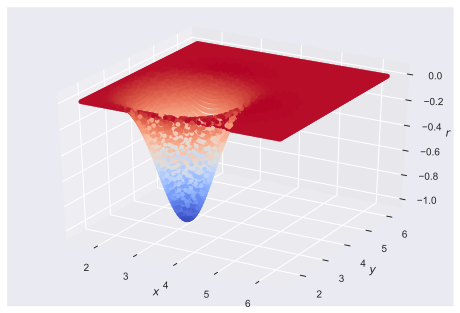

In [8]:
#create a lab
lab = epyc.Lab()

#initialise the params dict
lab['x'] = numpy.linspace( 0.5*numpy.pi, 2*numpy.pi, 100)
lab['y'] = numpy.linspace( 0.5*numpy.pi, 2*numpy.pi, 100)

#run the experiment
lab.runExperiment(user_experiment())

#create a dataframe using pandas
df = lab.notebook().dataframe()

#set up figure
fig = plt.figure()
ax = fig.gca(projection = '3d')

#plot graph
ax.scatter(df['x'], df['y'], df['r'], c = df['r'], depthshade = False, cmap = cm.coolwarm)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$r$')

plt.show()

From this we can clearly see the minima at $(x,y) = ( \pi, \pi )$. We will now use our optimisation algorithm to identify this point starting from a randomly chosen point in the parameter space. As remarked earlier only the third class needs to be modified, both `SimAnn` and `details` are functional without further adjustments. The final class however `user_section` does require some experiment-specific details. These include specifying how parameters are updated (`updates`), assimilating the cost function into the algorithm (`costfunction`) and creating an instance of the user's experimental class. In this case the `epyc` library has made things quite straightforward, but it is not a requirement. 

In [9]:
class user_section( details ):
    '''The sub-class tailors the experiment for the function we wish to minimise. This section is highly 
    user-defined and creates the random walk through the parameter space as well as the generation of the 
    cost function'''
    
    def __init__(self, parameters):
        super(user_section, self).__init__(parameters) 
        
        #max variation in parameters
        self._max_var = parameters['max_var']
        
    def null_updates( self, parameters ):
        '''function returns parameters without modification'''
        return parameters['prams']
        
    def updates( self, parameters ):
        '''function performs the updates in the parameter space. Returns dict of variables
        over which the new cost function will be evaluated. It is important to constrain the 
        search to physically meaningful submanifolds of the parameter space.'''
        
        #if first step in Markov chain use supplied values
        if self.temperature is self._initial_temperature:
            return parameters['prams']
        
        else:
            #load current minimum
            parameters['prams']['x'] = self.CURRENT_STATE['parameters']['x']
            parameters['prams']['y'] = self.CURRENT_STATE['parameters']['y']
            
            #perform random increment
            parameters['prams']['x'] += numpy.random.uniform(-1,1) * self._max_var
            parameters['prams']['y'] += numpy.random.uniform(-1,1) * self._max_var
        
            #check in range 
            if (0*numpy.pi > parameters['prams']['x']) or (parameters['prams']['x'] > 20*numpy.pi):
                parameters['prams']['x'] = self.CURRENT_STATE['parameters']['x']
            
            if (0*numpy.pi > parameters['prams']['y']) or (parameters['prams']['y'] > 20*numpy.pi):
                parameters['prams']['y'] = self.CURRENT_STATE['parameters']['y']
            
        return parameters['prams']
            
    def costfunction( self, variables ): 
        '''function generates the cost function for a particular parameter set (variables) and returns it's value. 
        The new state is then created as a particular realisation of the underlying experiment. Must set:
        
        self.NEW_INSTANCE 
        self.NEW_STATE 
        self.NEW_COST 
        
        If using epyc, will only have one 'new cost' line to update. '''
        
        #run a single experiment and set NEW proposal
        self.NEW_INSTANCE = self.create_model()
        self.NEW_STATE = self.NEW_INSTANCE.set( variables ).run()
        self.NEW_COST = self.NEW_STATE['results']['r']
    
    def create_model( self ):
        '''function produces the model that we evaluate the parameters over.  '''
        return user_experiment()
        

In [10]:
#initialise the prams dict 
prams = {'x': 2.0,
          'y': 2.0 }

#create parameter dict
parameters = {'initial_temperature': 1000, 
              'alpha': 0.9999,
              'initial_cost': 100, 
              'final_temperature': 0.00001,
              'max_var': 0.001,
              'prams': prams }

#create class instance
instance = user_section(parameters)

#run class experiment
src = instance.experiment()

In the above piece of code the experimental parameters were initialised and the algorithm was run. The output is a dictionary that contains the results of the optimisation and metadata about the experiment and the run-time. These can be accessed by one of the following keys. 

In [11]:
src.keys()

['Lowest',
 'Ratio',
 'Algorithm',
 'Proposal_History',
 'Instance',
 'State',
 'Cost',
 'criterion_list']

In [12]:
#should be -1
src['Lowest']['Cost']

-0.99999999975690934

In [13]:
#parameters x and y should be (pi,pi)
src['Lowest']['State']['parameters']

{'x': 3.1416036750743017, 'y': 3.1415862827686984}

In [14]:
src['Algorithm']

{'Accepted': 179035,
 'Moves': 184198,
 'Rejected': 5163,
 'time': 5.460448000000001}

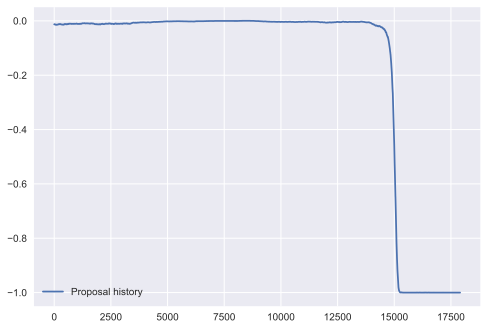

In [15]:
#set up the time series graph
fig = plt.figure()

#plot the current leading minimum over the course of the experiment
plt.plot(src['Proposal_History'][::10], label = 'Proposal history')

plt.legend()

plt.savefig('simAn.png')
_ = plt.show()

The proposal history is the currently minimal state that the Markov chain is exploring. Notice that it can *increase* over time, this is the whole point of simulated annealing - the algorithm can escape a local minimum. 

We can see that the the algorithm does in fact find the global minimum of the cost function to a high degree of accuracy. Recall that the value of the cost function was $-1$ at $(\pi, \pi)$ and our results were -0.999999999 at (3.1416, 3.1416) truncating a few digits. 

The downfall however is the computational waste associated with this result, nearly 20000 calculations were performed and it appears as if only the last 7000 were actually useful. This is in part my fault, if I had chosen a more efficient annealing schedule I'm sure that this could be improved, but as I say, its a bit of a black art. In fact I would love some suggestions on how to select alpha for a given problem.

## Better than a random walk?

There is an important question I would like to ask: "is our algorithm better than a random walk?". To test this we should set up a random walk in the parameter space and compute cost function. When it becomes as low as the output from the `simAnn` class, we break and record the time to run. Of course we must then average this over a number of trials. 

In [43]:
class RandomWalk( object ):
    ''' performs a random walk through the configuration space of the experiment
    while the cost function is greater than the result of our `simAnn` class. We 
    record the time for the experiment to complete. Can set a maximum number of 
    moves for manual time-out'''
    
    def __init__(self, params):
        
        self.maxMoves = params['maxMoves'] # the max number of moves before time-out
        self.target = params['target']     # target cost to beat
        self._max_var = params['maxvar']   # max parameter variation
        self.min_cost = params['min_cost'] # minimum cost on walk
        self._params = params               # the experimental parameters
               
    def update( self, params ):
        '''computes random updates in the parameters and checks if 
        they are still in appropriate range.'''
        
        # tempory record of parameters 
        temp = dict()
        temp['x'] = params['prams']['x']
        temp['y'] = params['prams']['y']
        
        # perform random increment
        params['prams']['x'] += numpy.random.uniform(-1,1) * self._max_var
        params['prams']['y'] += numpy.random.uniform(-1,1) * self._max_var
        
        # check in range 
        if (0*numpy.pi > params['prams']['x']) or (params['prams']['x'] > 20*numpy.pi):
            params['prams']['x'] = temp['x']
            
        if (0*numpy.pi > params['prams']['y']) or (params['prams']['y'] > 20*numpy.pi):
            params['prams']['y'] = temp['y']
            
        return params['prams']
        
    def costfunction( self, params ):
        '''returns the value of the cost function for a given parameters vector.'''
        # create class instance
        instance = user_experiment()

        # run a single class experiment
        src = instance.set(params['prams']).run()

        # return the value of the function (will later become our cost)
        return src['results']['r']
        
    def experiment( self ):
        '''runs the experiment while true'''
        
        param_history = list()
        cost_history = list()
        self.start_time = time.clock()
        self.moves = 0
        rc = dict() 
        
        while True: 
            
            # increase moves counter
            self.moves += 1
            
            # update parameters
            self.update(self._params)
            
            # evaluate the cost function
            cost = self.costfunction(self._params)
            
            # record cost history
            cost_history.append(cost)
            
            # record parameters
            param_history.append([self._params['prams']['x'] , self._params['prams']['y']])
            
            if cost < self.min_cost:
                self.min_cost = cost
            
            if cost <= self.target or self.moves >= self.maxMoves:
                rc['parameters'] = self._params
                rc['num_moves'] = self.moves
                rc['min_cost'] = self.min_cost
                rc['time'] = time.clock() - self.start_time
                rc['cost_history'] = cost_history
                rc['param_history'] =  param_history
                return rc      

In [44]:
#initialise the prams dict 
prams = {'x': 2.0,
          'y': 2.0 }

#create parameter dict
params = {'maxMoves': 1000000,
              'target': -0.999999999,
              'maxvar': 0.01,
              'min_cost': 100,
              'prams': prams }

# create instance of experiment
inst = RandomWalk(params)

# run the experiment
result = inst.experiment()

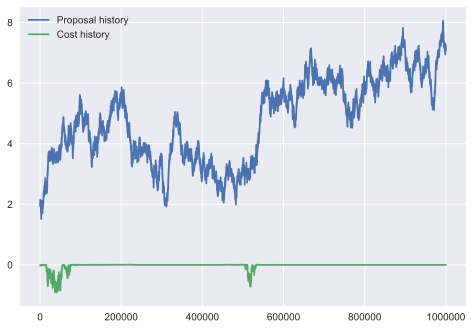

In [73]:
# set up the graph
fig = plt.figure()

# plot the random walk in the 'x' parameter
plt.plot([i[0] for i in result['param_history']], label = 'Proposal history')

# plot the cost
plt.plot(result['cost_history'], label = 'Cost history')

plt.legend()

plt.savefig('RandomWalk2.png')
_ = plt.show()

It is clear that the unguided random walk is disadvantaged compared to the simulated annealing class we tested earlier. There is no deliberate refinement of the parameters or descent of the cost function. Any optimisation is due to pure coincidence that the random walk happened to visit that part of the parameter space.